In [34]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import get_n_columns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [35]:
class BolTrend():
    def __init__(
        self,
        df,
        type=["long"],
        bol_window = 100,
        bol_std = 2.25,
        min_bol_spread = 0,
        long_ma_window = 500,
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.bol_window = bol_window
        self.bol_std = bol_std
        self.min_bol_spread = min_bol_spread
        self.long_ma_window = long_ma_window
        
    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=self.bol_window, window_dev=self.bol_std)
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()

        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=self.long_ma_window)

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['ma_band']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['ma_band']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       
        

In [36]:
pair = "BTC/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

Period: [2018-01-01 00:00:00] -> [2022-12-05 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 20156.01 $
Performance vs US dollar: 1915.6 %
Sharpe Ratio: 1.4
Worst Drawdown T|D: -27.61% | -31.38%
Buy and hold performance: 27.25 %
Performance vs buy and hold: 1483.92 %
Total trades on the period: 247
Global Win rate: 42.91 %
Average Profit: 1.45 %
Total fees paid 2932.47$

Best trades: +31.0 % the 2020-03-08 14:00:00 -> 2020-03-15 21:00:00
Worst trades: -13.46 % the 2019-07-02 04:00:00 -> 2019-07-03 00:00:00


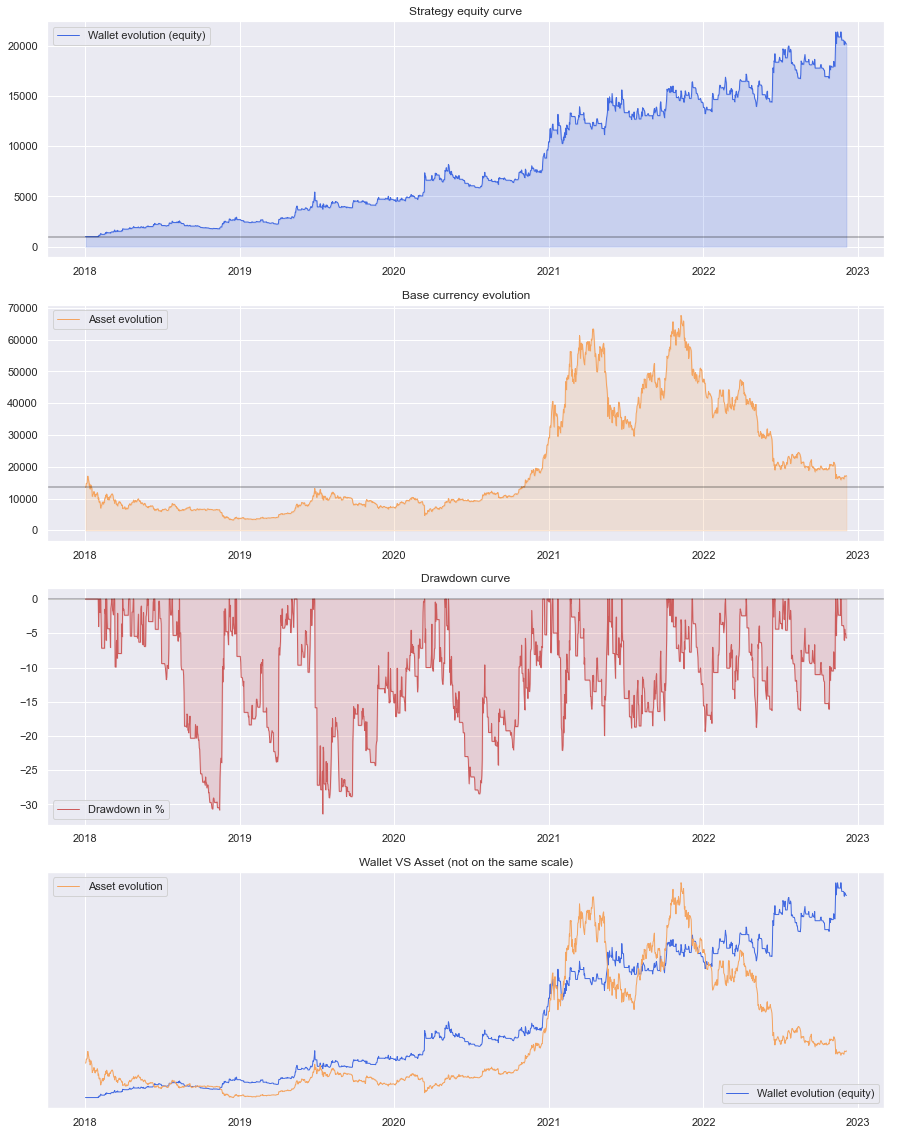

In [37]:
strat = BolTrend(
    df = df.loc["2018":],
    type=["long","short"],
    bol_window = 100,
    bol_std = 2.25,
    min_bol_spread = 0,
    long_ma_window = 500,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [38]:
df_trades

,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,
2018-01-30 15:00:00,2018-01-30 15:00:00,2018-02-07 09:00:00,SHORT,Market,Market,10323.02,7962.89,0.700000,0.859437,999.300000,1226.908386,1226.908386,226.908386,0.227067,0.156078,1226.908386,0.000000,0.000000
2018-02-15 02:00:00,2018-02-15 02:00:00,2018-02-21 03:00:00,LONG,Market,Market,9635.00,10915.34,0.858836,0.972281,1226.049550,1387.999976,1387.999976,161.091590,0.131391,0.103991,1387.999976,0.000000,0.000000
2018-02-27 08:00:00,2018-02-27 08:00:00,2018-03-06 02:00:00,LONG,Market,Market,10700.00,11282.71,0.971600,1.023795,1387.028376,1461.540591,1461.540591,73.540615,0.053020,0.047907,1461.540591,0.000000,0.000000
2018-03-07 16:00:00,2018-03-07 16:00:00,2018-03-11 17:00:00,SHORT,Market,Market,9910.02,9622.51,1.023078,1.052023,1460.517513,1501.838097,1501.838097,40.297506,0.027591,0.026131,1501.838097,0.000000,0.000000
2018-03-14 16:00:00,2018-03-14 16:00:00,2018-03-18 21:00:00,SHORT,Market,Market,8421.00,8225.01,1.051287,1.075001,1500.786811,1534.641058,1534.641058,32.802961,0.021857,0.020928,1534.641058,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04 12:00:00,2022-11-04 12:00:00,2022-11-07 05:00:00,LONG,Market,Market,20757.64,20858.95,12.508382,12.560632,17856.609072,17931.199632,17931.199632,62.082177,0.003477,0.003450,19376.876541,1445.676909,0.074608
2022-11-08 03:00:00,2022-11-08 03:00:00,2022-11-15 03:00:00,SHORT,Market,Market,20148.66,16823.06,12.551840,14.613324,17918.647792,20861.563907,20861.563907,2930.364275,0.163537,0.123166,20861.563907,0.000000,0.000000
2022-11-20 21:00:00,2022-11-20 21:00:00,2022-11-23 02:00:00,SHORT,Market,Market,16284.23,16512.44,14.603095,14.388366,20846.960812,20540.419552,20540.419552,-321.144355,-0.015405,-0.015883,20861.563907,321.144355,0.015394


----- 2018 Cumulative Performances: 169.44% -----


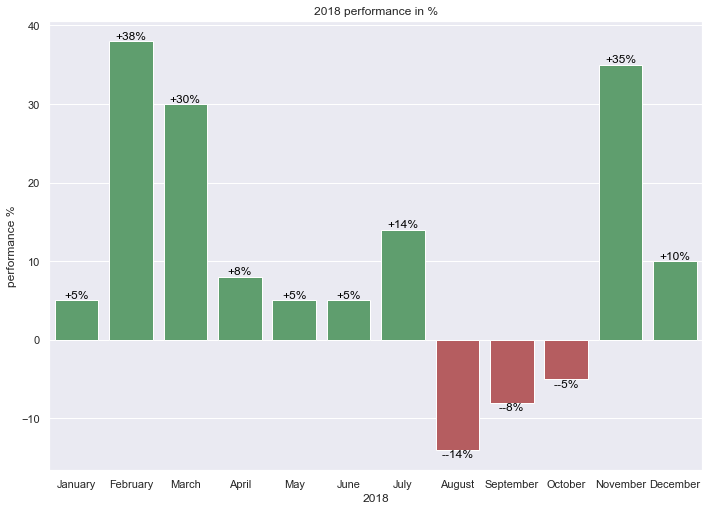

----- 2019 Cumulative Performances: 71.31% -----


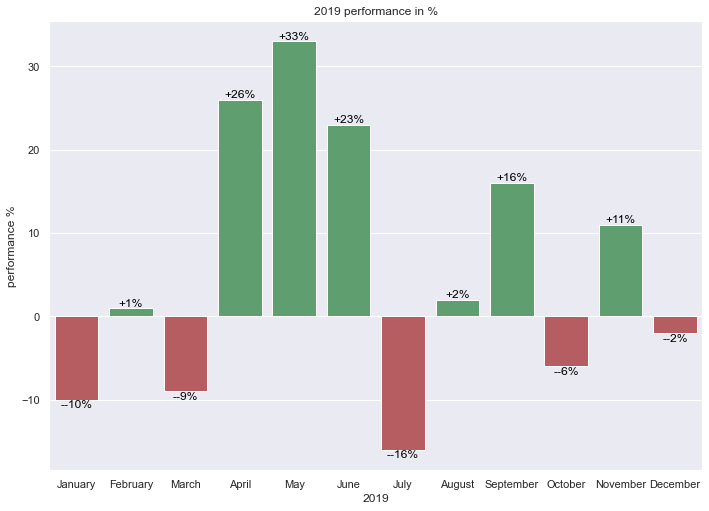

----- 2020 Cumulative Performances: 126.02% -----


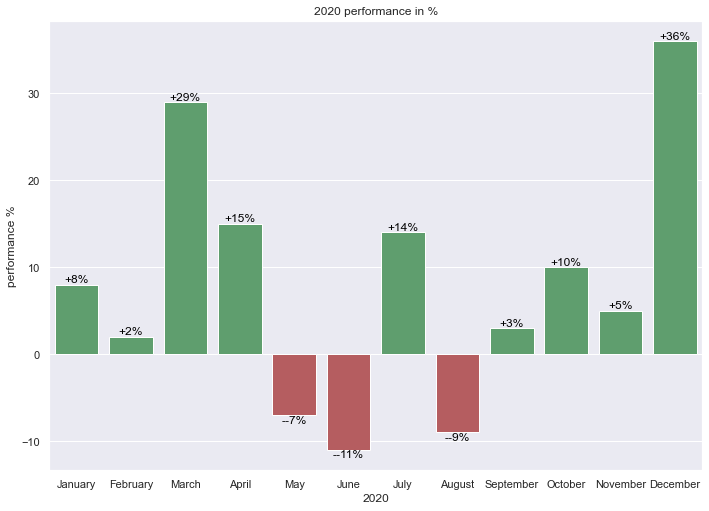

----- 2021 Cumulative Performances: 37.29% -----


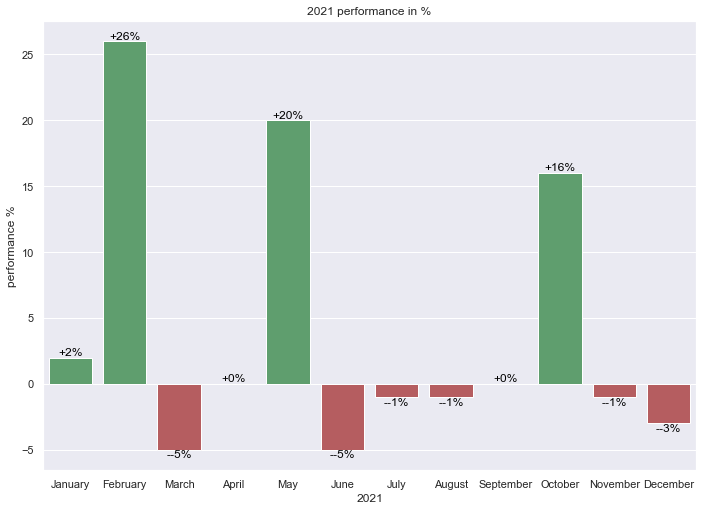

----- 2022 Cumulative Performances: 45.59% -----


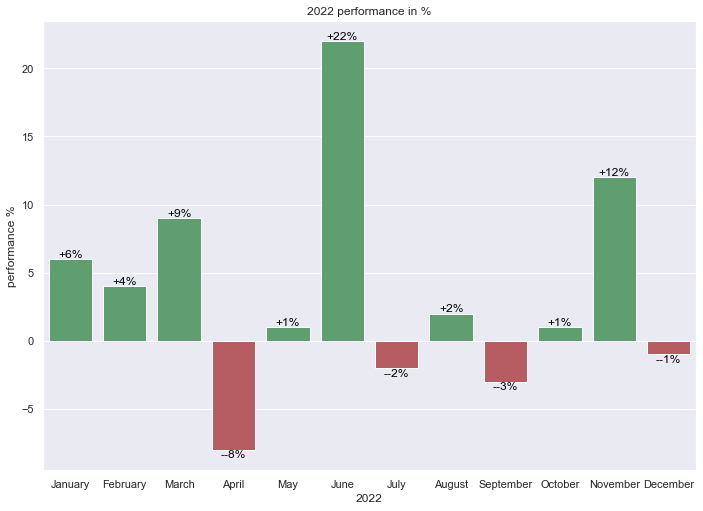

KeyError: '2023-1'

In [39]:
plot_bar_by_month(df_days=df_days)